# Getting started with TensorFlow (Eager Mode)

**Learning Objectives**
  - Understand difference between Tensorflow's two modes: Eager Execution and Graph Execution
  - Practice defining and performing basic operations on constant Tensors
  - Use Tensorflow's automatic differentiation capability

## Introduction

**Eager Execution**

Eager mode evaluates operations immediatley and return concrete values immediately. To enable eager mode simply place `tf.enable_eager_execution()` at the top of your code. We recommend using eager execution when prototyping as it is intuitive, easier to debug, and requires less boilerplate code.

**Graph Execution**

Graph mode is TensorFlow's default execution mode (although it will change to eager with TF 2.0). In graph mode operations only produce a symbolic graph which doesn't get executed until run within the context of a tf.Session(). This style of coding is less inutitive and has more boilerplate, however it can lead to performance optimizations and is particularly suited for distributing training across multiple devices. We recommend using delayed execution for performance sensitive production code. 

In [1]:
# Ensure that we have Tensorflow 1.13.1 installed.
!pip3 freeze | grep tensorflow==1.13.1 || pip3 install tensorflow==1.13.1

tensorflow==1.13.1


In [2]:
import tensorflow as tf
print(tf.__version__)

1.13.1


## Eager Execution

In [3]:
tf.enable_eager_execution() 

### Adding Two Tensors 

The value of the tensor, as well as its shape and data type are printed

In [4]:
a = tf.constant(value = [5, 3, 8], dtype = tf.int32)
b = tf.constant(value = [3, -1, 2], dtype = tf.int32)
c = tf.add(x = a, y = b)
print(c)

tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)


#### Overloaded Operators
We can also perform a `tf.add()` using the `+` operator. The `/,-,*` and `**` operators are similarly overloaded with the appropriate tensorflow operation.

In [5]:
c = a + b # this is equivalent to tf.add(a,b)
print(c)

tf.Tensor([ 8  2 10], shape=(3,), dtype=int32)


### NumPy Interoperability

In addition to native TF tensors, tensorflow operations can take native python types and NumPy arrays as operands. 

In [6]:
import numpy as np 

a_py = [1,2] # native python list
b_py = [3,4] # native python list

a_np = np.array(object = [1,2]) # numpy array
b_np = np.array(object = [3,4]) # numpy array

a_tf = tf.constant(value = [1,2], dtype = tf.int32) # native TF tensor
b_tf = tf.constant(value = [3,4], dtype = tf.int32) # native TF tensor

for result in [tf.add(x = a_py, y = b_py), tf.add(x = a_np, y = b_np), tf.add(x = a_tf, y = b_tf)]:
    print("Type: {}, Value: {}".format(type(result), result))

Type: <class 'tensorflow.python.framework.ops.EagerTensor'>, Value: [4 6]
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>, Value: [4 6]
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>, Value: [4 6]


You can convert a native TF tensor to a NumPy array using .numpy()

In [7]:
a_tf.numpy()

array([1, 2], dtype=int32)

### Linear Regression

Now let's use low level tensorflow operations to implement linear regression.

Later in the course you'll see abstracted ways to do this using high level TensorFlow.

#### Toy Dataset

We'll model the following function:

\begin{equation}
y= 2x + 10
\end{equation}

In [8]:
X = tf.constant(value = [1,2,3,4,5,6,7,8,9,10], dtype = tf.float32)
Y = 2 * X + 10
print("X:{}".format(X))
print("Y:{}".format(Y))

X:[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Y:[12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]


#### Loss Function

Using mean squared error, our loss function is:
\begin{equation}
MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{Y}_i-Y_i)^2
\end{equation}

$\hat{Y}$ represents the vector containing our model's predictions:
\begin{equation}
\hat{Y} = w_0X + w_1
\end{equation}

In [9]:
def loss_mse(X, Y, w0, w1):
    Y_hat = w0 * X + w1
    return tf.reduce_mean(input_tensor = (Y_hat - Y)**2)

#### Gradient Function

To use gradient descent we need to take the partial derivative of the loss function with respect to each of the weights. We could manually compute the derivatives, but with Tensorflow's automatic differentiation capabilities we don't have to!

During gradient descent we think of the loss as a function of the parameters $w_0$ and $w_1$. Thus, we want to compute the partial derivative with respect to these variables. The `params=[2,3]` argument tells TensorFlow to only compute derivatives with respect to the 2nd and 3rd arguments to the loss function (counting from 0, so really the 3rd and 4th).

In [10]:
# Counting from 0, the 2nd and 3rd parameter to the loss function are our weights
grad_f = tf.contrib.eager.gradients_function(f = loss_mse, params=[2,3])


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Training Loop

Here we have a very simple training loop that converges. Note we are ignoring best practices like batching, creating a separate test set, and random weight initialization for the sake of simplicity.

In [11]:
STEPS = 1000
LEARNING_RATE = .02

# Initialize weights
w0 = tf.constant(value = 0.0, dtype = tf.float32)
w1 = tf.constant(value = 0.0, dtype = tf.float32)

for step in range(STEPS):
    #1. Calculate gradients
    d_w0, d_w1 = grad_f(X, Y, w0, w1)

    #2. Update weights
    w0 = w0 - d_w0 * LEARNING_RATE
    w1 = w1 - d_w1 * LEARNING_RATE

    #3. Periodically print MSE
    if step % 100 == 0:
        print("STEP: {} MSE: {}".format(step, loss_mse(X, Y, w0, w1)))

# Print final MSE and weights
print("STEP: {} MSE: {}".format(STEPS,loss_mse(X, Y, w0, w1)))
print("w0:{}".format(round(float(w0), 4)))
print("w1:{}".format(round(float(w1), 4)))

STEP: 0 MSE: 167.6111297607422
STEP: 100 MSE: 3.5321757793426514
STEP: 200 MSE: 0.6537718176841736
STEP: 300 MSE: 0.12100745737552643
STEP: 400 MSE: 0.022397063672542572
STEP: 500 MSE: 0.004145540297031403
STEP: 600 MSE: 0.0007674093940295279
STEP: 700 MSE: 0.00014202017337083817
STEP: 800 MSE: 2.628635775181465e-05
STEP: 900 MSE: 4.86889211970265e-06
STEP: 1000 MSE: 9.178326081382693e-07
w0:2.0003
w1:9.9979


## Bonus

Try modelling a non-linear function such as: $y=xe^{-x^2}$

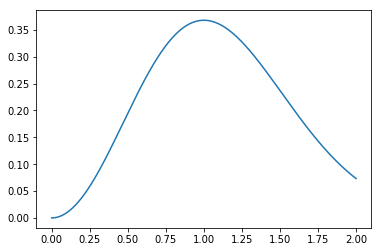

In [12]:
X = tf.constant(value = np.linspace(0,2,1000), dtype = tf.float32)
Y = X*np.exp(-X**2) * X

from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(X, Y)

In [13]:
def make_features(X):
    features = [X]
    features.append(tf.ones_like(X))  # Bias.
    features.append(tf.square(X))
    features.append(tf.sqrt(X))
    features.append(tf.exp(X))
    return tf.stack(features, axis=1)

def make_weights(n_weights):
    W = [tf.constant(value = 0.0, dtype = tf.float32) for _ in range(n_weights)]
    return tf.expand_dims(tf.stack(W),-1)

def predict(X, W):
    Y_hat = tf.matmul(X, W)
    return tf.squeeze(Y_hat, axis=-1)

def loss_mse(X, Y, W):
    Y_hat = predict(X, W)
    return tf.reduce_mean(input_tensor = (Y_hat - Y)**2)

X = tf.constant(value = np.linspace(0,2,1000), dtype = tf.float32)
Y = np.exp(-X**2) * X

grad_f = tf.contrib.eager.gradients_function(f = loss_mse, params=[2])

STEP: 2000 MSE: 0.0029543826822191477


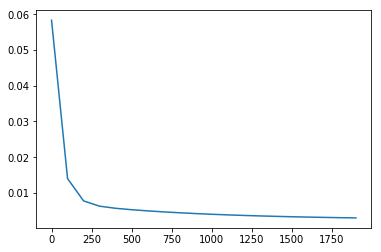

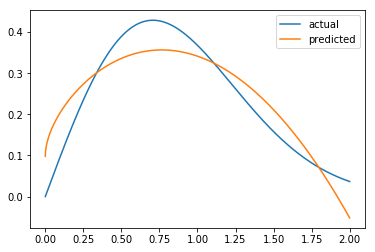

In [15]:
STEPS = 2000
LEARNING_RATE = .01

# Weights/features.
Xf = make_features(X)
# Xf = Xf[:,0:2]  # Linear features only.
W = make_weights(Xf.get_shape()[1].value)

# For plotting
steps = []
losses = []

plt.figure()
for step in range(STEPS):
    #1. Calculate gradients
    dW = grad_f(Xf, Y, W)[0]
    #2. Update weights
    W -= dW * LEARNING_RATE
    #3. Periodically print MSE
    if step % 100 == 0:
        loss = loss_mse(Xf, Y, W)
        steps.append(step)
        losses.append(loss)
        plt.clf()
        plt.plot(steps, losses)
# Print final MSE and weights
print("STEP: {} MSE: {}".format(STEPS,loss_mse(Xf, Y, W)))

# Plot results
plt.figure()
plt.plot(X, Y, label='actual')
plt.plot(X, predict(Xf, W), label='predicted')
plt.legend()

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License